In [1]:
import torch
import torchvision

dtype = torch.float32
USE_GPU = True
device = 0
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('вычисляем на:', device)


вычисляем на: cuda


In [2]:
from dataset import get_dataloader
batch_size = 20

In [3]:
train_dataloader = get_dataloader('./MURA-v1.1/train_image_paths.csv',
                                  './MURA-v1.1/train_labeled_studies.csv',
                                  'train',
                                  batch_size,
                                  False,
                                  split=1,
                                  num_workers=0)
valid_dataloader = get_dataloader('./MURA-v1.1/valid_image_paths.csv',
                                  './MURA-v1.1/valid_labeled_studies.csv',
                                  'valid',
                                  batch_size,
                                  False,
                                  split=1,
                                  num_workers=0)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('normal','abnormal')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


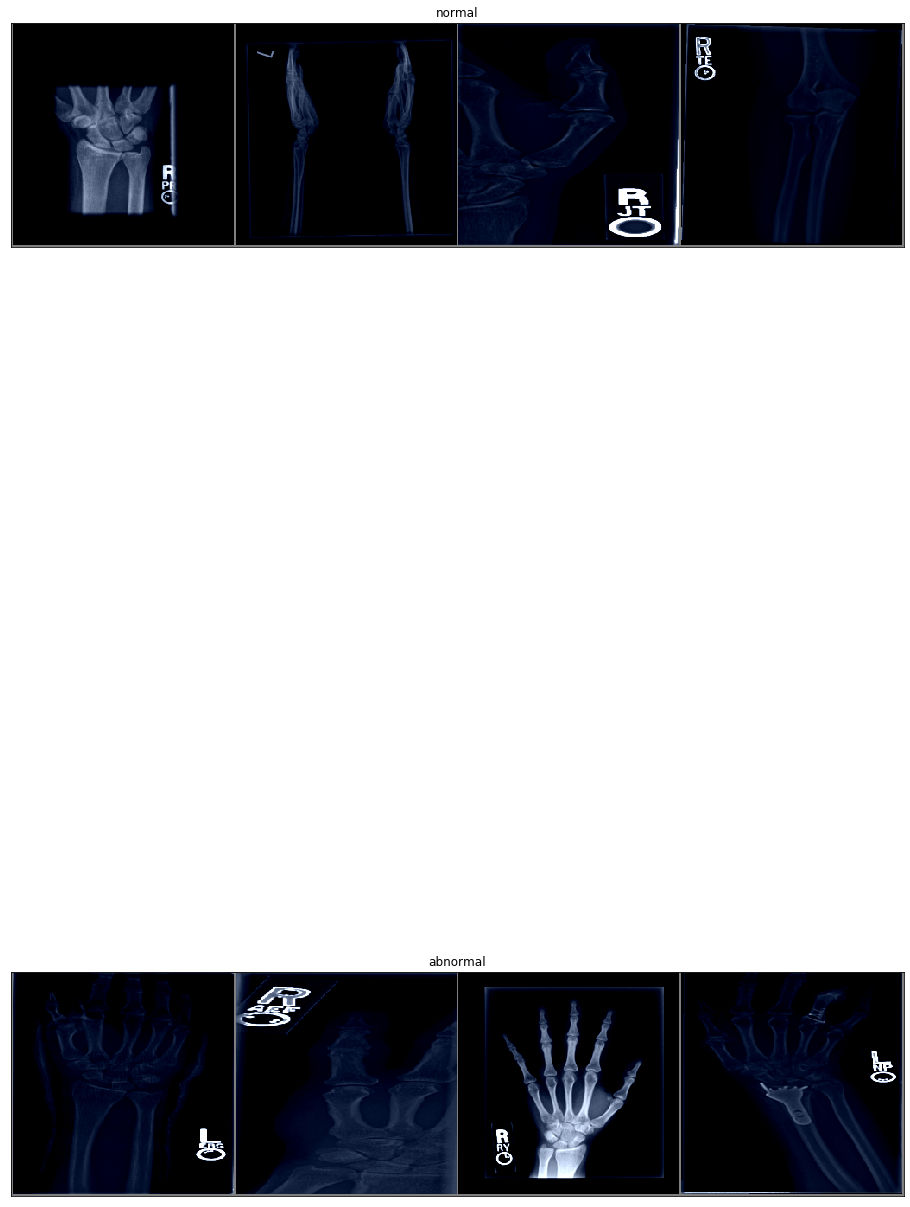

In [5]:
fig, axs = plt.subplots(2,1)
fig.set_figwidth(16)
fig.set_figheight(32)
def imshow(img, idx, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    axs[idx].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[idx].set_title(title)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

counts = {classes[i]: 4 for i in range(2)}
imgs_and_labels = {classes[i]: [] for i in range(2)}

for j in range(batch_size):
    if counts[classes[labels[j]]] > 0:
        imgs_and_labels[classes[labels[j]]].append(images[j])
        counts[classes[labels[j]]]-=1

class_id =0
for key in imgs_and_labels.keys():
    imshow(torchvision.utils.make_grid(imgs_and_labels[key]),class_id, classes[class_id])
    class_id+=1
plt.show()

In [6]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)\n\n' %
              (num_correct, num_samples, 100 * acc))
        return acc

In [7]:
import torch.nn.functional as F
def train(model, optimizer, device, epochs):
    model = model.to(device=device)
    Loss = []
    train_accuracy = []
    valid_accuracy = []
    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch:{e}, loss = {loss.item()}\n')
        train_accuracy.append(check_accuracy(train_dataloader, model))
        valid_accuracy.append(check_accuracy(valid_dataloader, model))
        Loss.append(loss.item())
    return Loss, train_accuracy, valid_accuracy

In [8]:
from model import densenet121
model = densenet121()

In [9]:
import torch.optim as optim

learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
epochs = 20

In [10]:
Loss, train_acc, valid_acc = [], [], []

In [11]:
tmp = train(model, optimizer, device, epochs)
Loss += tmp[0]
train_acc += tmp[1]
valid_acc += tmp[2]

Epoch:0, loss = 0.41435515880584717

Got 23324 / 36808 correct (63.37)


Got 1953 / 3197 correct (61.09)


Epoch:1, loss = 0.4756418764591217

Got 24495 / 36808 correct (66.55)


Got 2021 / 3197 correct (63.22)


Epoch:2, loss = 0.4737562835216522

Got 26489 / 36808 correct (71.97)


Got 2152 / 3197 correct (67.31)


Epoch:3, loss = 0.6101257801055908

Got 27577 / 36808 correct (74.92)


Got 2218 / 3197 correct (69.38)


Epoch:4, loss = 0.684765100479126

Got 27682 / 36808 correct (75.21)


Got 2258 / 3197 correct (70.63)


Epoch:5, loss = 0.601327121257782

Got 28158 / 36808 correct (76.50)


Got 2250 / 3197 correct (70.38)


Epoch:6, loss = 0.3932289779186249

Got 28417 / 36808 correct (77.20)


Got 2240 / 3197 correct (70.07)


Epoch:7, loss = 0.6155709624290466

Got 28923 / 36808 correct (78.58)


Got 2245 / 3197 correct (70.22)


Epoch:8, loss = 0.5868816375732422

Got 28139 / 36808 correct (76.45)


Got 2200 / 3197 correct (68.81)


Epoch:9, loss = 1.0297596454620361

Got 29936 /

In [19]:
true_labels =[]
predicted_labels =[]
model.eval()
with torch.no_grad():
    for data in valid_dataloader:
        images, labels = data
        images = images.to(device = device, dtype = dtype)
        labels = labels.to(device = device, dtype = torch.long)
        outputs = model(images)
        _, predict= torch.max(outputs, 1)        
        for label in labels:
            true_labels.append(label.item())
        for pred in predict:
            predicted_labels.append(pred.item())

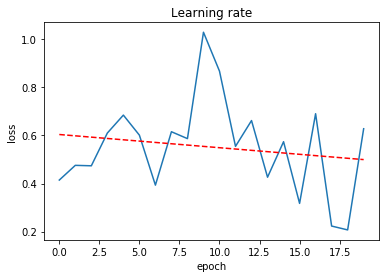

In [20]:
epoch_arr = [i for i in range(len(Loss))]
plt.title("Learning rate")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(epoch_arr, Loss)
z = np.polyfit(epoch_arr, Loss, 1)
p = np.poly1d(z)
plt.plot(epoch_arr, p(epoch_arr), 'r--')
plt.show()

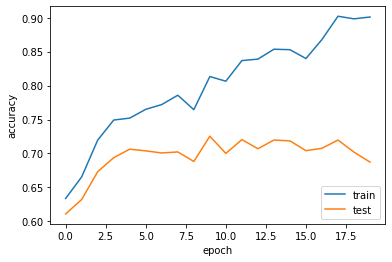

In [21]:
fig, ax = plt.subplots()
ax.plot(epoch_arr, train_acc, epoch_arr, valid_acc)
lgnd = ax.legend(['train', 'test'], loc='lower right')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [22]:
import sklearn.metrics as metrics
import pandas as pd

precission, recall, f1, _ = metrics.precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
norm_confusion_matrix = confusion_matrix / confusion_matrix.astype(np.float).sum(axis=1)
print(f'precission: {precission}', f'recall: {recall}', f'f1: {f1}', f'accuracy: {accuracy}')


precission: 0.7238175675675675 recall: 0.5601307189542484 f1: 0.6315401621223287 accuracy: 0.6872067563340631


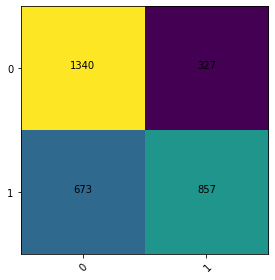

In [23]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)
columns = [0,1]
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(columns)):
    for j in range(len(columns)):
        text = ax.text(j, i, round(confusion_matrix[i][j],3),
                       ha="center", va="baseline", color="k")
fig.tight_layout()
plt.show()

In [24]:
labels = true_labels + [y.item() for _, yy in train_dataloader for y in yy]

(array([23602., 16403.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

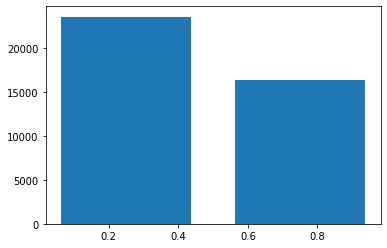

In [25]:
plt.hist(labels, bins=2, rwidth=0.75)